/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


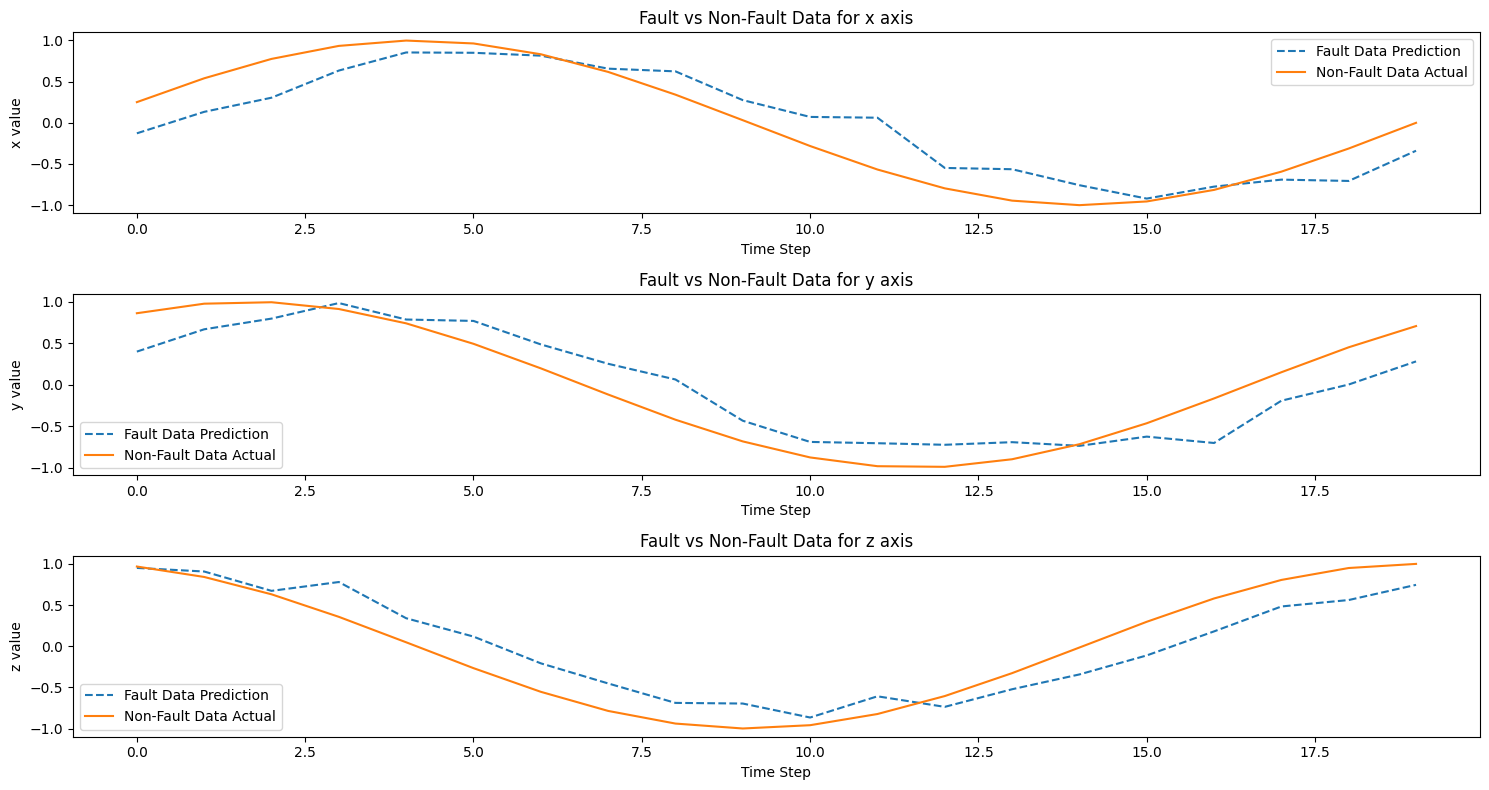

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import math

# Define Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size=3, d_model=64, nhead=4, num_layers=3, output_size=3 * 20):
        super(TransformerModel, self).__init__()
        self.input_fc = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=256)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.fc_out(x[:, -1, :])  # Use the last time step for prediction
        return x

# Initialize parameters
input_length = 80
output_length = 20
model = TransformerModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Load the data
def load_data(file_path, input_length=80, output_length=20):
    data = pd.read_csv(file_path)
    sequences = []
    for i in range(len(data) - (input_length + output_length)):
        sequence = data.iloc[i:i + input_length + output_length][['x', 'y', 'z']].values
        sequences.append(sequence)

    inputs = [seq[:input_length] for seq in sequences]
    targets = [seq[input_length:] for seq in sequences]
    inputs = torch.tensor(inputs, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.float32).reshape(len(sequences), -1)
    return TensorDataset(inputs, targets)

# Predict function for Transformer model
def predict(model, dataset):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            outputs = model(inputs)
            predictions.append(outputs.view(-1, 3).numpy())  # Reshape for plotting

    return np.concatenate(predictions, axis=0)

# Plot comparison
def plot_comparison(fault_predictions, non_fault_data):
    plt.figure(figsize=(15, 8))
    for i, axis in enumerate(['x', 'y', 'z']):
        plt.subplot(3, 1, i + 1)
        plt.plot(fault_predictions[:, i], label='Fault Data Prediction', linestyle='--')
        plt.plot(non_fault_data[-len(fault_predictions):, i], label='Non-Fault Data Actual', linestyle='-')
        plt.title(f'Fault vs Non-Fault Data for {axis} axis')
        plt.xlabel('Time Step')
        plt.ylabel(f'{axis} value')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Load model state
model_path = '/Users/prasanna/Desktop/Hack2Future/transformer_model.pth'
model.load_state_dict(torch.load(model_path))

# Load datasets
fault_data_file = "/Users/prasanna/Desktop/Hack2Future/peak_drop_fault_data.csv"  # Fault data path
non_fault_data_file = "/Users/prasanna/Desktop/Hack2Future/_non_fault_data.csv"  # Non-fault data path
fault_dataset = load_data(fault_data_file, input_length, output_length)
non_fault_dataset = load_data(non_fault_data_file, input_length, output_length)

# Make predictions
fault_predictions = predict(model, fault_dataset)
non_fault_data = pd.read_csv(non_fault_data_file)[['x', 'y', 'z']].values

# Plot comparison of the last 20 entries
plot_comparison(fault_predictions[-20:], non_fault_data)
